In [1]:
#pip install scikit-optimize

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
import aqi

from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

import pickle
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from keras.models import Sequential

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.layers import Activation

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import tensorflow as tf
from tensorflow import keras

from datetime import datetime

import random

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [2]:
#next add lag features by converting time series to supervised.
#function to ad lead and lag features.
# convert series to supervised learning
#Reference : https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
# split data into train ,validation and test sets
def split_data(data,reshape='no',n_hours = 1, n_features = 10):
    values = data.values
    #use data for 2015-2017 for training, 2018-2019 for validation and 2020 for testing
    #train = values[:26304, :]
    train = values[:26265, :]
    #valid = values[26304:43824, :]
    valid = values[26265:43785, :]
    #test = values[43824:, :]
    test = values[43785:, :]
    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    valid_X,valid_y = valid[:, :n_obs], valid[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    if reshape=='yes':
        train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
        valid_X = valid_X.reshape((valid_X.shape[0], n_hours, n_features))
        test_X  = test_X.reshape((test_X.shape[0], n_hours, n_features))
    return train_X, train_y, valid_X, valid_y, test_X, test_y

In [4]:
#Try this
def split_ml(data,n_hours = 1, n_features = 10):
    values = data.values
    #use data for 2015-2017 for training, 2018-2019 for validation and 2020 for testing

    train = values[:43785, :]

    test = values[43785:, :]
    # split into input and outputs
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]

    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    
    return train_X, train_y, test_X, test_y

In [5]:
#function to calculate different error metrics for models
#references https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/
def model_evaluation(y_actual,y_predicted):
    #rmse
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    #mae
    mae=mean_absolute_error(y_actual, y_predicted)
    #mape
    mape = mean_absolute_error(y_actual, y_predicted)*100
    #r2
    r2=r2_score(y_actual, y_predicted)
    return rmse, mae, mape,r2

In [6]:
#ref https://www.kaggle.com/rohanrao/calculating-aqi-air-quality-index-tutorial
#https://pypi.org/project/python-aqi/

#PM10: 604
#PM25: 500

#Ozone: 0.37
#CO:50

def AQI_cal(value,pollutant):
    
    if value <0:
        value=0
    
    if pollutant=='CO':
        if value <=50:
            maqi=aqi.to_iaqi(aqi.POLLUTANT_CO_8H, value, algo=aqi.ALGO_EPA)
        else :
            maqi=500

    elif pollutant=='OZONE':
        maqi= aqi.to_iaqi(aqi.POLLUTANT_O3_8H, value, algo=aqi.ALGO_EPA)
        
    elif pollutant=='PM25':
        if value <=500:
            maqi= aqi.to_iaqi(aqi.POLLUTANT_PM25, value, algo=aqi.ALGO_EPA)
        else:
            maqi=500
        
    elif pollutant=='PM10':
        if value <=600:
            maqi= aqi.to_iaqi(aqi.POLLUTANT_PM10, value, algo=aqi.ALGO_EPA)
        else:
            maqi=600
        
    return maqi

In [7]:
def AQI_level(value):
    if value <= 50:
        return "Good"
    elif value <= 100:
        return "Moderate"
    elif value <= 150:
        return "UnHealthy for Sensitive Groups"
    elif value <= 200:
        return "UnHealthy"
    elif value <= 300:
        return "Very UnHealthy"
    elif value > 300:
        return "Hazardous"
    else:
        return np.NaN

In [8]:
#prepare data for models
#Load scaler
scaler=pickle.load(open('scaler.pkl', 'rb'))

In [9]:
#Load best models for CO, Ozone, PM2.5 and PM10.
#Inverse results and create one single dataframe with results for test data
#Create aqi for all and final aqi value.
#For Flask prepare functions for each.

In [10]:
df=pd.read_csv('Hourly_Preprocessed_Dataset.csv',index_col=0,parse_dates=True)
df.head()

,CO,NO2,OZONE,PM10,PM25,SO2,Barometric_Pressure,Dewpoint,Relative_Humidity,Temperature,Wind_Speed,season,weekend_flag,peak_hours
2015-01-02 10:00:00,-0.482597,-0.599879,-0.182026,-0.063857,-0.093282,0.005219,1.331716,-0.390781,-0.359205,-1.371250,0.224861,3,1,0
2015-01-02 11:00:00,-0.496857,-0.717961,0.095772,-0.155189,-0.093282,-0.124040,1.143620,-0.524329,-0.536764,-1.154079,-0.152468,3,1,0
2015-01-02 12:00:00,-0.513493,-0.763377,0.289706,-0.312401,0.166494,-0.253299,0.977468,-1.337763,-0.762775,-0.895541,-0.392585,3,1,0
2015-01-02 13:00:00,-0.454077,-0.708877,0.289706,-0.358815,-0.014666,-0.382557,0.914769,-1.532016,-0.777822,-0.802467,-0.907124,3,1,0
2015-01-02 14:00:00,-0.437441,-0.708877,0.394536,-0.351329,0.039597,-0.382557,0.852070,-1.871958,-0.782035,-0.750760,-0.598401,3,1,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52574 entries, 2015-01-02 10:00:00 to 2020-12-31 23:00:00
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CO                   52574 non-null  float64
 1   NO2                  52574 non-null  float64
 2   OZONE                52574 non-null  float64
 3   PM10                 52574 non-null  float64
 4   PM25                 52574 non-null  float64
 5   SO2                  52574 non-null  float64
 6   Barometric_Pressure  52574 non-null  float64
 7   Dewpoint             52574 non-null  float64
 8   Relative_Humidity    52574 non-null  float64
 9   Temperature          52574 non-null  float64
 10  Wind_Speed           52574 non-null  float64
 11  season               52574 non-null  int64  
 12  weekend_flag         52574 non-null  int64  
 13  peak_hours           52574 non-null  int64  
dtypes: float64(11), int64(3)
memory usage: 6.0 MB


In [12]:
df.index.dtype

dtype('<M8[ns]')

In [13]:
df.drop(columns=['season', 'weekend_flag','peak_hours'],inplace=True)

In [14]:
# Extract month
df["month"] = df.index.month
#Creating new column season
df.loc[df['month'] == 3,'season'] ='spring'
df.loc[df['month'] == 4,'season'] ='spring'
df.loc[df['month'] == 5,'season'] ='spring'
df.loc[df['month'] == 6,'season'] ='summer'
df.loc[df['month'] == 7,'season'] ='summer'
df.loc[df['month'] == 8,'season'] ='summer'
df.loc[df['month'] == 9,'season'] ='autumn'
df.loc[df['month'] == 10,'season'] ='autumn'
df.loc[df['month'] == 11,'season'] ='autumn'
df.loc[df['month'] == 12,'season'] ='winter'
df.loc[df['month'] == 1,'season'] ='winter'
df.loc[df['month'] == 2,'season'] ='winter'

df.drop(columns=[ 'month'],inplace=True)

In [15]:
X=df['CO']
Y=df['SO2']
Z=df['OZONE']

Text(0.5, 0.92, '3D Plot')

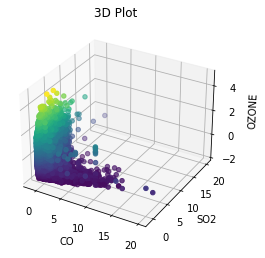

In [16]:
#3d plots

from mpl_toolkits import mplot3d

import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X, Y, Z,c=Z, cmap='viridis')
#ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                #cmap='winter', edgecolor='none')
ax.set_xlabel('CO')
ax.set_ylabel('SO2')
ax.set_zlabel('OZONE')
ax.set_title('3D Plot')

In [17]:
#Dataset to hold final results
df_model_results = pd.DataFrame(columns = ['dates','CO_Original','CO_Predicted','AQI_CO_Original','AQI_CO_Predicted',
                                           'Ozone_Original','Ozone_Predicted','AQI_Ozone_Original','AQI_Ozone_Predicted',
                                           'PM25_Original','PM25_Predicted','AQI_PM25_Original','AQI_PM25_Predicted',
                                           'PM10_Original','PM10_Predicted','AQI_PM10_Original','AQI_PM10_Predicted','Final_AQI_Original','Final_AQI_Predicted'])

In [18]:
start=time.time()
print("hello 1")
# specify the number of lag hours
n_hours = 5
n_features = 9 #number of features in dataframe to be used

# frame as supervised learning with previous 5 hours data to predict upcoming hour data.
scaled_CO=df.iloc[:,[0,1,2,3,5,6,8,9,10]].values
reframed_CO = series_to_supervised(scaled_CO, n_hours, 1)
print(reframed_CO.shape)

#CO:
CO_train_X, CO_train_y, CO_valid_X, CO_valid_y, CO_test_X, CO_test_y=split_data(reframed_CO,reshape='yes',n_hours=n_hours,n_features=n_features) #for lstm 3d data is required
print("training data CO:",CO_train_X.shape, len(CO_train_X), CO_train_y.shape,)
print("validation data CO:",CO_valid_X.shape, len(CO_valid_X), CO_valid_y.shape)
print("testing data CO:",CO_test_X.shape, len(CO_test_X), CO_test_y.shape)

hello 1
(52569, 54)
training data CO: (26265, 5, 9) 26265 (26265,)
validation data CO: (17520, 5, 9) 17520 (17520,)
testing data CO: (8784, 5, 9) 8784 (8784,)


In [19]:
#Random code
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#Documents/Fall2021/Code/CO_LSTM_model.h5
model_CO = tf.keras.models.load_model('best_model_CO.h5')

yhat=model_CO.predict(CO_test_X)
yhat = np.repeat(yhat, 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,0]

end=time.time()
print("CO Test time:", end-start)

CO Test time: 2.3020362854003906


In [20]:
# invert scaling for actual values
y_actual=CO_test_y.reshape(len(CO_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,0]

In [21]:
#Model Evaluation with 100 epochs, 50 units
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 0.151
Test MAE: 0.075
Test MAPE: 7.458
Test R2: 0.835


In [22]:
dates=df.index[43790:]

In [23]:
df_model_results['dates']=pd.to_datetime(dates)

df_model_results['CO_Original']=inv_y
df_model_results['CO_Predicted']=inv_yhat

In [24]:
df_model_results['AQI_CO_Original']=df_model_results.CO_Original.apply(AQI_cal,pollutant='CO')
df_model_results['AQI_CO_Predicted']=df_model_results.CO_Predicted.apply(AQI_cal,pollutant='CO')#, giving error

In [25]:
df_model_results.head()

,dates,CO_Original,CO_Predicted,AQI_CO_Original,AQI_CO_Predicted,Ozone_Original,Ozone_Predicted,AQI_Ozone_Original,AQI_Ozone_Predicted,PM25_Original,PM25_Predicted,AQI_PM25_Original,AQI_PM25_Predicted,PM10_Original,PM10_Predicted,AQI_PM10_Original,AQI_PM10_Predicted,Final_AQI_Original,Final_AQI_Predicted
0,2020-01-01 00:00:00,0.319,0.841170,3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 01:00:00,0.303,0.200024,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 02:00:00,0.413,0.238461,5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01 03:00:00,0.705,0.411592,8,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01 04:00:00,0.705,0.794992,8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Ozone

In [26]:
#ozone
start=time.time()
# specify the number of lag hours
n_hours = 5
n_features = 6 #number of features in dataframe to be used

# frame as supervised learning
scaled_Ozone=df.iloc[:,[2,0,1,8,9,10]].values
reframed_Ozone = series_to_supervised(scaled_Ozone, n_hours, 1)
print(reframed_Ozone.shape)

#PM10:
Ozone_train_X, Ozone_train_y, Ozone_valid_X, Ozone_valid_y, Ozone_test_X, Ozone_test_y=split_data(reframed_Ozone,reshape='yes',n_hours=n_hours,n_features=n_features) #for lstm 3d data is required
print("training data Ozone:",Ozone_train_X.shape, len(Ozone_train_X), Ozone_train_y.shape,)
print("validation data Ozone:",Ozone_valid_X.shape, len(Ozone_valid_X), Ozone_test_X.shape)
print("testing data Ozone:",Ozone_test_X.shape, len(Ozone_test_X), Ozone_test_y.shape)

(52569, 36)
training data Ozone: (26265, 5, 6) 26265 (26265,)
validation data Ozone: (17520, 5, 6) 17520 (8784, 5, 6)
testing data Ozone: (8784, 5, 6) 8784 (8784,)


In [27]:
#Random code
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model_Ozone = tf.keras.models.load_model('best_model_Ozone.h5')

yhat=model_Ozone.predict(Ozone_test_X)
yhat = np.repeat(yhat, 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,2]

end=time.time()
print("Ozone Test time:", end-start)

Ozone Test time: 1.2200675010681152


In [28]:
# invert scaling for actual values
y_actual=Ozone_test_y.reshape(len(Ozone_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,2]

In [29]:
#Model Evaluation
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 0.005
Test MAE: 0.004
Test MAPE: 0.372
Test R2: 0.924


In [30]:
df_model_results['Ozone_Original']=inv_y
df_model_results['Ozone_Predicted']=inv_yhat

In [31]:
df_model_results['AQI_Ozone_Original']=df_model_results.Ozone_Original.apply(AQI_cal,pollutant='OZONE')
df_model_results['AQI_Ozone_Predicted']=df_model_results.Ozone_Predicted.apply(AQI_cal,pollutant='OZONE')

In [32]:
df_model_results.Ozone_Original.max()

0.1079

In [33]:
df_model_results.head(3)

,dates,CO_Original,CO_Predicted,AQI_CO_Original,AQI_CO_Predicted,Ozone_Original,Ozone_Predicted,AQI_Ozone_Original,AQI_Ozone_Predicted,PM25_Original,PM25_Predicted,AQI_PM25_Original,AQI_PM25_Predicted,PM10_Original,PM10_Predicted,AQI_PM10_Original,AQI_PM10_Predicted,Final_AQI_Original,Final_AQI_Predicted
0,2020-01-01 00:00:00,0.319,0.841170,3,9,0.0142,0.004176,12,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 01:00:00,0.303,0.200024,3,2,0.0205,0.017260,17,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 02:00:00,0.413,0.238461,5,2,0.0151,0.016980,13,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### PM2.5

In [34]:
#PM2.5
# specify the number of lag hours
start=time.time()
n_hours = 5
n_features = 7 #number of features in dataframe to be used

# frame as supervised learning
scaled_PM25=df.iloc[:,[4,3,6,7,8,9,10]].values
reframed_PM25 = series_to_supervised(scaled_PM25, n_hours, 1)
print(reframed_PM25.shape)

#PM25:
PM25_train_X, PM25_train_y, PM25_test_X, PM25_test_y=split_ml(reframed_PM25,n_hours=n_hours,n_features=n_features) #for lstm 3d data is required

print("training data CO:",PM25_train_X.shape, len(PM25_train_X), PM25_train_y.shape)
print("testing data CO:",PM25_test_X.shape, len(PM25_test_X), PM25_test_y.shape)

(52569, 42)
training data CO: (43785, 35) 43785 (43785,)
testing data CO: (8784, 35) 8784 (8784,)


In [35]:
Pkl_Filename = "best_model_PM25.pkl"  

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_rf_Model = pickle.load(file)

yhat=Pickled_rf_Model.predict(PM25_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,4]

end=time.time()
print("PM 2.5 Test time:", end-start)

PM 2.5 Test time: 0.965364933013916


In [36]:
# invert scaling for actual values
y_actual=PM25_test_y.reshape(len(PM25_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,4]

In [37]:
#Model Evaluation
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 4.210
Test MAE: 2.495
Test MAPE: 249.507
Test R2: 0.539


In [38]:
df_model_results['PM25_Original']=inv_y
df_model_results['PM25_Predicted']=inv_yhat

In [39]:
df_model_results['AQI_PM25_Original']=df_model_results.PM25_Original.apply(AQI_cal,pollutant='PM25')
df_model_results['AQI_PM25_Predicted']=df_model_results.PM25_Predicted.apply(AQI_cal,pollutant='PM25')

In [40]:
df_model_results.head(3)

,dates,CO_Original,CO_Predicted,AQI_CO_Original,AQI_CO_Predicted,Ozone_Original,Ozone_Predicted,AQI_Ozone_Original,AQI_Ozone_Predicted,PM25_Original,PM25_Predicted,AQI_PM25_Original,AQI_PM25_Predicted,PM10_Original,PM10_Predicted,AQI_PM10_Original,AQI_PM10_Predicted,Final_AQI_Original,Final_AQI_Predicted
0,2020-01-01 00:00:00,0.319,0.841170,3,9,0.0142,0.004176,12,3,1.24,2.916377,5,12,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 01:00:00,0.303,0.200024,3,2,0.0205,0.017260,17,14,1.24,2.893128,5,12,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 02:00:00,0.413,0.238461,5,2,0.0151,0.016980,13,14,1.24,2.356894,5,10,NaN,NaN,NaN,NaN,NaN,NaN


### PM10

In [41]:
# specify the number of lag hours
start=time.time()
n_hours = 5
n_features =7 #number of features in dataframe to be used

# frame as supervised learning
scaled_PM10=df.iloc[:,[3,0,1,2,4,5,10]].values
reframed_PM10 = series_to_supervised(scaled_PM10, n_hours, 1)
print(reframed_PM10.shape)


#PM10:
PM10_train_X, PM10_train_y, PM10_test_X, PM10_test_y=split_ml(reframed_PM10,n_hours=n_hours,n_features=n_features) #for lstm 3d data is required

print("training data PM10:",PM10_train_X.shape, len(PM10_train_X), PM10_train_y.shape)
print("testing data PM10:",PM10_test_X.shape, len(PM10_test_X), PM10_test_y.shape)

(52569, 42)
training data PM10: (43785, 35) 43785 (43785,)
testing data PM10: (8784, 35) 8784 (8784,)


In [42]:
Pkl_Filename = "best_model_PM10.pkl"  

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_rf_Model = pickle.load(file)

yhat=Pickled_rf_Model.predict(PM10_test_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,3]

end=time.time()
print("PM10 Test time:", end-start)

PM10 Test time: 1.1169965267181396


In [43]:
# invert scaling for actual values
y_actual=PM10_test_y.reshape(len(PM10_test_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,3]

In [44]:
#Model Evaluation,grid search random forest
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 37.830
Test MAE: 16.460
Test MAPE: 1646.022
Test R2: 0.546


In [45]:
df_model_results['PM10_Original']=inv_y
df_model_results['PM10_Predicted']=inv_yhat

In [46]:
df_model_results['AQI_PM10_Original']=df_model_results.PM10_Original.apply(AQI_cal,pollutant='PM10')
df_model_results['AQI_PM10_Predicted']=df_model_results.PM10_Predicted.apply(AQI_cal,pollutant='PM10')

In [47]:
df_model_results.head()

,dates,CO_Original,CO_Predicted,AQI_CO_Original,AQI_CO_Predicted,Ozone_Original,Ozone_Predicted,AQI_Ozone_Original,AQI_Ozone_Predicted,PM25_Original,PM25_Predicted,AQI_PM25_Original,AQI_PM25_Predicted,PM10_Original,PM10_Predicted,AQI_PM10_Original,AQI_PM10_Predicted,Final_AQI_Original,Final_AQI_Predicted
0,2020-01-01 00:00:00,0.319,0.841170,3,9,0.0142,0.004176,12,3,1.24,2.916377,5,12,39.0,73.281604,36,60,NaN,NaN
1,2020-01-01 01:00:00,0.303,0.200024,3,2,0.0205,0.017260,17,14,1.24,2.893128,5,12,28.7,30.844698,26,28,NaN,NaN
2,2020-01-01 02:00:00,0.413,0.238461,5,2,0.0151,0.016980,13,14,1.24,2.356894,5,10,43.3,29.078647,40,27,NaN,NaN
3,2020-01-01 03:00:00,0.705,0.411592,8,5,0.0075,0.013307,6,11,1.24,2.664890,5,11,76.8,43.489391,61,40,NaN,NaN
4,2020-01-01 04:00:00,0.705,0.794992,8,8,0.0075,0.005664,6,4,1.24,3.086626,5,12,100.4,77.501782,73,62,NaN,NaN


In [48]:
#To calculate final AQI level
df_model_results["Final_AQI_Original"] = (df_model_results[["AQI_CO_Original", "AQI_Ozone_Original",
                                                                 "AQI_PM25_Original", "AQI_PM10_Original"]].max(axis = 1))

In [49]:
df_model_results['Final_AQI_Predicted'] = (df_model_results[["AQI_CO_Predicted", "AQI_Ozone_Predicted",
                                                                 "AQI_PM25_Predicted", "AQI_PM10_Predicted"]].max(axis = 1))

In [50]:
df_model_results['Original_AQI_LEVEL'] = df_model_results["Final_AQI_Original"].apply(AQI_level)
df_model_results['Predicted_AQI_LEVEL'] = df_model_results["Final_AQI_Predicted"].apply(AQI_level)

In [51]:
df_model_results

,dates,CO_Original,CO_Predicted,AQI_CO_Original,AQI_CO_Predicted,Ozone_Original,Ozone_Predicted,AQI_Ozone_Original,AQI_Ozone_Predicted,PM25_Original,...,AQI_PM25_Original,AQI_PM25_Predicted,PM10_Original,PM10_Predicted,AQI_PM10_Original,AQI_PM10_Predicted,Final_AQI_Original,Final_AQI_Predicted,Original_AQI_LEVEL,Predicted_AQI_LEVEL
0,2020-01-01 00:00:00,0.319,0.841170,3,9,0.0142,0.004176,12,3,1.24,...,5,12,39.0,73.281604,36,60,36.0,60.0,Good,Moderate
1,2020-01-01 01:00:00,0.303,0.200024,3,2,0.0205,0.017260,17,14,1.24,...,5,12,28.7,30.844698,26,28,26.0,28.0,Good,Good
2,2020-01-01 02:00:00,0.413,0.238461,5,2,0.0151,0.016980,13,14,1.24,...,5,10,43.3,29.078647,40,27,40.0,27.0,Good,Good
3,2020-01-01 03:00:00,0.705,0.411592,8,5,0.0075,0.013307,6,11,1.24,...,5,11,76.8,43.489391,61,40,61.0,40.0,Moderate,Good
4,2020-01-01 04:00:00,0.705,0.794992,8,8,0.0075,0.005664,6,4,1.24,...,5,12,100.4,77.501782,73,62,73.0,62.0,Moderate,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2020-12-31 19:00:00,0.283,0.221560,2,2,0.0178,0.022100,14,19,10.00,...,42,10,46.8,27.336355,43,25,43.0,25.0,Good,Good
8780,2020-12-31 20:00:00,0.440,0.361533,5,3,0.0109,0.014286,8,12,28.00,...,84,20,70.3,48.801010,58,44,84.0,44.0,Moderate,Good
8781,2020-12-31 21:00:00,0.298,0.463873,2,5,0.0219,0.012593,18,10,2.00,...,8,59,39.4,72.109345,36,59,36.0,59.0,Good,Moderate
8782,2020-12-31 22:00:00,0.288,0.249562,2,2,0.0246,0.021084,20,18,2.00,...,8,17,29.6,37.196577,27,34,27.0,34.0,Good,Good


In [52]:
y_actual=df_model_results['Original_AQI_LEVEL']
y_predicted=df_model_results['Predicted_AQI_LEVEL']

In [54]:
from sklearn.metrics import multilabel_confusion_matrix

y_unique = y_actual.unique()

mcm=multilabel_confusion_matrix(y_actual, y_predicted, labels = y_unique)



In [55]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_actual, y_predicted))


Classification Report

                                precision    recall  f1-score   support

                          Good       0.84      0.88      0.86      5053
                     Hazardous       0.00      0.00      0.00        20
                      Moderate       0.71      0.71      0.71      3170
                     UnHealthy       0.18      0.15      0.16        41
UnHealthy for Sensitive Groups       0.64      0.34      0.45       485
                Very UnHealthy       0.00      0.00      0.00        15

                      accuracy                           0.78      8784
                     macro avg       0.39      0.35      0.36      8784
                  weighted avg       0.77      0.78      0.77      8784



In [56]:
df_model_results['Original_AQI_LEVEL'].value_counts()

Good                              5053
Moderate                          3170
UnHealthy for Sensitive Groups     485
UnHealthy                           41
Hazardous                           20
Very UnHealthy                      15
Name: Original_AQI_LEVEL, dtype: int64

In [57]:
df_model_results['Predicted_AQI_LEVEL'].value_counts()

Good                              5279
Moderate                          3207
UnHealthy for Sensitive Groups     261
UnHealthy                           34
Very UnHealthy                       2
Hazardous                            1
Name: Predicted_AQI_LEVEL, dtype: int64

In [58]:
error_count=0
for i,j in zip(y_actual,y_predicted):
    if i!=j:
        error_count+=1

In [59]:
print(error_count)

1919


In [60]:
actual_count=len(y_actual)

In [61]:
accuracy=(actual_count-error_count)/actual_count

In [63]:
accuracy

0.7815346083788707

In [64]:
df_model_results.index= pd.to_datetime(df_model_results.dates)

In [65]:
#Creating new column season
df_model_results.loc[df_model_results.index.month == 3,'season'] ='spring'
df_model_results.loc[df_model_results.index.month == 4,'season'] ='spring'
df_model_results.loc[df_model_results.index.month == 5,'season'] ='spring'
df_model_results.loc[df_model_results.index.month == 6,'season'] ='summer'
df_model_results.loc[df_model_results.index.month == 7,'season'] ='summer'
df_model_results.loc[df_model_results.index.month == 8,'season'] ='summer'
df_model_results.loc[df_model_results.index.month == 9,'season'] ='autumn'
df_model_results.loc[df_model_results.index.month == 10,'season'] ='autumn'
df_model_results.loc[df_model_results.index.month == 11,'season'] ='autumn'
df_model_results.loc[df_model_results.index.month == 12,'season'] ='winter'
df_model_results.loc[df_model_results.index.month == 1,'season'] ='winter'
df_model_results.loc[df_model_results.index.month == 2,'season'] ='winter'


df_model_results.drop(columns=['dates'],inplace=True)

In [66]:
df_model_results

,CO_Original,CO_Predicted,AQI_CO_Original,AQI_CO_Predicted,Ozone_Original,Ozone_Predicted,AQI_Ozone_Original,AQI_Ozone_Predicted,PM25_Original,PM25_Predicted,...,AQI_PM25_Predicted,PM10_Original,PM10_Predicted,AQI_PM10_Original,AQI_PM10_Predicted,Final_AQI_Original,Final_AQI_Predicted,Original_AQI_LEVEL,Predicted_AQI_LEVEL,season
dates,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.319,0.841170,3,9,0.0142,0.004176,12,3,1.24,2.916377,...,12,39.0,73.281604,36,60,36.0,60.0,Good,Moderate,winter
2020-01-01 01:00:00,0.303,0.200024,3,2,0.0205,0.017260,17,14,1.24,2.893128,...,12,28.7,30.844698,26,28,26.0,28.0,Good,Good,winter
2020-01-01 02:00:00,0.413,0.238461,5,2,0.0151,0.016980,13,14,1.24,2.356894,...,10,43.3,29.078647,40,27,40.0,27.0,Good,Good,winter
2020-01-01 03:00:00,0.705,0.411592,8,5,0.0075,0.013307,6,11,1.24,2.664890,...,11,76.8,43.489391,61,40,61.0,40.0,Moderate,Good,winter
2020-01-01 04:00:00,0.705,0.794992,8,8,0.0075,0.005664,6,4,1.24,3.086626,...,12,100.4,77.501782,73,62,73.0,62.0,Moderate,Moderate,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,0.283,0.221560,2,2,0.0178,0.022100,14,19,10.00,2.553768,...,10,46.8,27.336355,43,25,43.0,25.0,Good,Good,winter
2020-12-31 20:00:00,0.440,0.361533,5,3,0.0109,0.014286,8,12,28.00,4.951914,...,20,70.3,48.801010,58,44,84.0,44.0,Moderate,Good,winter
2020-12-31 21:00:00,0.298,0.463873,2,5,0.0219,0.012593,18,10,2.00,15.703354,...,59,39.4,72.109345,36,59,36.0,59.0,Good,Moderate,winter


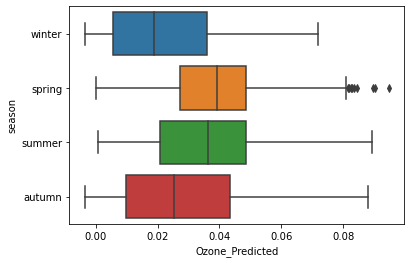

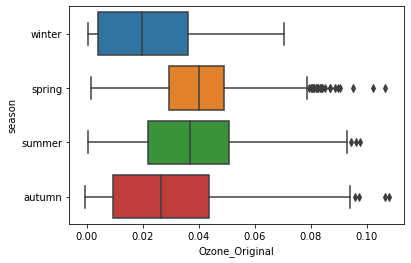

In [67]:
#fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=df_model_results[['Ozone_Predicted','Ozone_Original']],x=df_model_results.Ozone_Predicted,y=df_model_results.season)
plt.show()
sns.boxplot(data=df_model_results[['Ozone_Predicted','Ozone_Original']],x=df_model_results.Ozone_Original,y=df_model_results.season)
plt.show()

<AxesSubplot:>

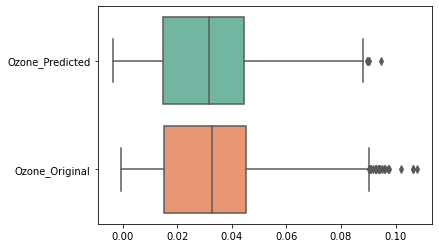

In [68]:
sns.boxplot(data=df_model_results[['Ozone_Predicted','Ozone_Original']], orient="h", palette="Set2")

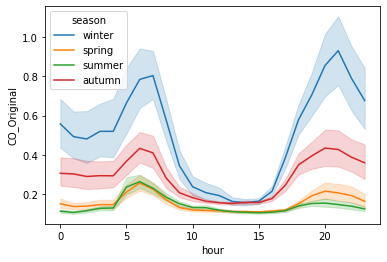

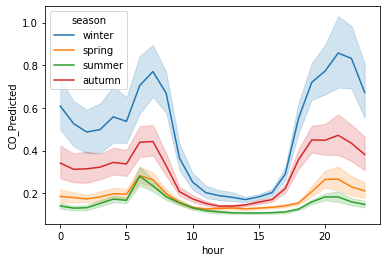

In [69]:
sns.lineplot(
    data=df_model_results, 
    x=df_model_results.index.hour, y="CO_Original",hue='season')
plt.xlabel('hour')
plt.show()
sns.lineplot(
    data=df_model_results, 
    x=df_model_results.index.hour, y="CO_Predicted",hue='season')
plt.xlabel('hour')
plt.show()

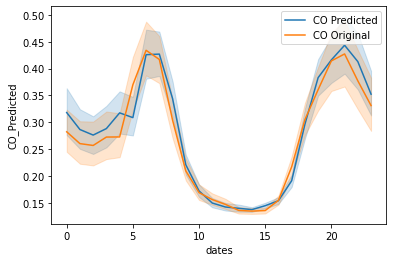

In [70]:
sns.lineplot(
    data=df_model_results, 
    x=df_model_results.index.hour, y="CO_Predicted",label='CO Predicted')

sns.lineplot(
    data=df_model_results, 
    x=df_model_results.index.hour, y="CO_Original", label='CO Original')

plt.legend()

In [71]:
df_model_results.to_csv('TestData_Model_Results.csv', index=True)

## QA Testing

In [72]:
df_qa=pd.read_csv('Preprocessed_2021.csv',index_col=0,parse_dates=True)
df_qa.head()

,CO,NO2,OZONE,PM10,PM25,SO2,Barometric_Pressure,Dewpoint,Relative_Humidity,Temperature,Wind_Speed,season,weekend_flag,peak_hours
2021-01-01 00:00:00,-0.225918,-0.518130,-0.318304,-0.192620,0.059678,-0.382557,-1.117612,-1.944803,-0.057957,-1.329884,-0.529796,3,1,0
2021-01-01 01:00:00,-0.176009,-0.581713,-0.014299,-0.462126,-0.068501,-0.382557,-1.094648,-1.944803,-0.163890,-1.267835,-0.083862,3,1,0
2021-01-01 02:00:00,-0.206905,-0.545380,-0.103404,-0.477098,-0.196680,-0.382557,-1.043314,-1.944803,-0.019436,-1.412616,-0.358283,3,1,0
2021-01-01 03:00:00,0.244659,-0.054887,-0.596102,-0.566933,-0.196680,-0.253299,-1.001619,-1.944803,0.283918,-1.485007,-0.426888,3,1,0
2021-01-01 04:00:00,0.244659,-0.054887,-0.596102,-0.581906,-0.196680,-0.253299,-0.927086,-1.944803,0.293549,-1.433299,-0.426888,3,1,0


In [73]:
df_qa.drop(columns=['season', 'weekend_flag','peak_hours'],inplace=True)

In [74]:
# Extract month
df_qa["month"] = df_qa.index.month
#Creating new column season
df_qa.loc[df_qa['month'] == 3,'season'] ='spring'
df_qa.loc[df_qa['month'] == 4,'season'] ='spring'
df_qa.loc[df_qa['month'] == 5,'season'] ='spring'
df_qa.loc[df_qa['month'] == 6,'season'] ='summer'
df_qa.loc[df_qa['month'] == 7,'season'] ='summer'
df_qa.loc[df_qa['month'] == 8,'season'] ='summer'
df_qa.loc[df_qa['month'] == 9,'season'] ='autumn'
df_qa.loc[df_qa['month'] == 10,'season'] ='autumn'
df_qa.loc[df_qa['month'] == 11,'season'] ='autumn'
df_qa.loc[df_qa['month'] == 12,'season'] ='winter'
df_qa.loc[df_qa['month'] == 1,'season'] ='winter'
df_qa.loc[df_qa['month'] == 2,'season'] ='winter'

df_qa.drop(columns=[ 'month'],inplace=True)

In [75]:
#Dataset to hold final results
df_qa_results = pd.DataFrame(columns = ['dates','CO_Original','CO_Predicted','AQI_CO_Original','AQI_CO_Predicted',
                                           'Ozone_Original','Ozone_Predicted','AQI_Ozone_Original','AQI_Ozone_Predicted',
                                           'PM25_Original','PM25_Predicted','AQI_PM25_Original','AQI_PM25_Predicted',
                                           'PM10_Original','PM10_Predicted','AQI_PM10_Original','AQI_PM10_Predicted','Final_AQI_Original','Final_AQI_Predicted'])

In [76]:
def data_split(data,n_hours,n_features,reshape):
    values = data.values
    n_obs = n_hours * n_features
    QA_X, QA_y = values[:, :n_obs], values[:, -n_features]
    if reshape=='yes':
        QA_X  = QA_X.reshape((QA_X.shape[0], n_hours, n_features))
    
    return QA_X, QA_y 

In [77]:
# specify the number of lag hours
start=time.time()
n_hours = 5
n_features = 9 #number of features in dataframe to be used

# frame as supervised learning with previous 5 hours data to predict upcoming hour data.
scaled_CO=df_qa.iloc[:,[0,1,2,3,5,6,8,9,10]].values
reframed_CO = series_to_supervised(scaled_CO, n_hours, 1)
print(reframed_CO.shape)

CO_QA_X,CO_QA_y=data_split(reframed_CO,n_hours,n_features,'yes')

print("QA data CO:",CO_QA_X.shape, len(CO_QA_X), CO_QA_y.shape)

(2155, 54)
QA data CO: (2155, 5, 9) 2155 (2155,)


In [78]:
#Random code
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

#Documents/Fall2021/Code/CO_LSTM_model.h5
model_CO = tf.keras.models.load_model('best_model_CO.h5')

yhat=model_CO.predict(CO_QA_X)
yhat = np.repeat(yhat, 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,0]

# invert scaling for actual values
y_actual=CO_QA_y.reshape(len(CO_QA_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,0]

end=time.time()
print("CO Runtime is ",end-start)

CO Runtime is  1.3440051078796387


In [79]:
#Model Evaluation with 100 epochs, 50 units
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 0.196
Test MAE: 0.113
Test MAPE: 11.339
Test R2: 0.786


In [80]:
dates=df_qa.index[5:]

In [81]:
df_qa_results['dates']=pd.to_datetime(dates)

df_qa_results['CO_Original']=inv_y
df_qa_results['CO_Predicted']=inv_yhat

In [82]:
df_qa_results['AQI_CO_Original']=df_qa_results.CO_Original.apply(AQI_cal,pollutant='CO')
df_qa_results['AQI_CO_Predicted']=df_qa_results.CO_Predicted.apply(AQI_cal,pollutant='CO')#, giving error

In [83]:
df_qa_results.head()

,dates,CO_Original,CO_Predicted,AQI_CO_Original,AQI_CO_Predicted,Ozone_Original,Ozone_Predicted,AQI_Ozone_Original,AQI_Ozone_Predicted,PM25_Original,PM25_Predicted,AQI_PM25_Original,AQI_PM25_Predicted,PM10_Original,PM10_Predicted,AQI_PM10_Original,AQI_PM10_Predicted,Final_AQI_Original,Final_AQI_Predicted
0,2021-01-01 05:00:00,0.250,0.502920,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 06:00:00,0.149,0.318372,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 07:00:00,0.136,0.203902,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01 08:00:00,0.162,0.208163,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01 09:00:00,0.128,0.197779,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Ozone

In [84]:
#ozone
start=time.time()
# specify the number of lag hours
n_hours = 5
n_features = 6 #number of features in dataframe to be used

# frame as supervised learning
scaled_Ozone=df_qa.iloc[:,[2,0,1,8,9,10]].values
reframed_Ozone = series_to_supervised(scaled_Ozone, n_hours, 1)
print(reframed_Ozone.shape)

Ozone_QA_X,Ozone_QA_y=data_split(reframed_Ozone,n_hours,n_features,'yes')

print("QA data Ozone:",Ozone_QA_X.shape, len(Ozone_QA_X), Ozone_QA_y.shape)

(2155, 36)
QA data Ozone: (2155, 5, 6) 2155 (2155,)


In [85]:
#Random code
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model_Ozone = tf.keras.models.load_model('best_model_Ozone.h5')

yhat=model_Ozone.predict(Ozone_QA_X)
yhat = np.repeat(yhat, 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,2]

# invert scaling for actual values
y_actual=Ozone_QA_y.reshape(len(Ozone_QA_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,2]

end=time.time()
print("Ozone Runtime is ",end-start)

Ozone Runtime is  2.6976141929626465


In [86]:
#Model Evaluation
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 0.005
Test MAE: 0.003
Test MAPE: 0.322
Test R2: 0.923


In [87]:
df_qa_results['Ozone_Original']=inv_y
df_qa_results['Ozone_Predicted']=inv_yhat

In [88]:
df_qa_results['AQI_Ozone_Original']=df_qa_results.Ozone_Original.apply(AQI_cal,pollutant='OZONE')
df_qa_results['AQI_Ozone_Predicted']=df_qa_results.Ozone_Predicted.apply(AQI_cal,pollutant='OZONE')

In [89]:
df_qa_results.Ozone_Original.max()

0.0766

In [90]:
df_qa_results.head(3)

,dates,CO_Original,CO_Predicted,AQI_CO_Original,AQI_CO_Predicted,Ozone_Original,Ozone_Predicted,AQI_Ozone_Original,AQI_Ozone_Predicted,PM25_Original,PM25_Predicted,AQI_PM25_Original,AQI_PM25_Predicted,PM10_Original,PM10_Predicted,AQI_PM10_Original,AQI_PM10_Predicted,Final_AQI_Original,Final_AQI_Predicted
0,2021-01-01 05:00:00,0.250,0.502920,2,6,0.0226,0.019145,19,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 06:00:00,0.149,0.318372,1,3,0.0254,0.023018,21,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 07:00:00,0.136,0.203902,1,2,0.0286,0.026256,24,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### PM2.5

In [91]:
#PM2.5
# specify the number of lag hours
start=time.time()
n_hours = 5
n_features = 7 #number of features in dataframe to be used

# frame as supervised learning
scaled_PM25=df_qa.iloc[:,[4,3,6,7,8,9,10]].values
reframed_PM25 = series_to_supervised(scaled_PM25, n_hours, 1)
print(reframed_PM25.shape)

PM25_QA_X,PM25_QA_y=data_split(reframed_PM25,n_hours,n_features,'no')

print("QA data PM 2.5:",PM25_QA_X.shape, len(PM25_QA_X), PM25_QA_y.shape)


(2155, 42)
QA data PM 2.5: (2155, 35) 2155 (2155,)


In [92]:
Pkl_Filename = "best_model_PM25.pkl"  

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_rf_Model = pickle.load(file)

yhat=Pickled_rf_Model.predict(PM25_QA_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,4]

# invert scaling for actual values
y_actual=PM25_QA_y.reshape(len(PM25_QA_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,4]

end=time.time()
print("PM2.5 Runtime is ",end-start)

PM2.5 Runtime is  0.7140705585479736


In [93]:
#Model Evaluation
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 3.661
Test MAE: 2.267
Test MAPE: 226.709
Test R2: 0.432


In [94]:
df_qa_results['PM25_Original']=inv_y
df_qa_results['PM25_Predicted']=inv_yhat

In [95]:
df_qa_results['AQI_PM25_Original']=df_qa_results.PM25_Original.apply(AQI_cal,pollutant='PM25')
df_qa_results['AQI_PM25_Predicted']=df_qa_results.PM25_Predicted.apply(AQI_cal,pollutant='PM25')

In [96]:
df_qa_results.head(3)

,dates,CO_Original,CO_Predicted,AQI_CO_Original,AQI_CO_Predicted,Ozone_Original,Ozone_Predicted,AQI_Ozone_Original,AQI_Ozone_Predicted,PM25_Original,PM25_Predicted,AQI_PM25_Original,AQI_PM25_Predicted,PM10_Original,PM10_Predicted,AQI_PM10_Original,AQI_PM10_Predicted,Final_AQI_Original,Final_AQI_Predicted
0,2021-01-01 05:00:00,0.250,0.502920,2,6,0.0226,0.019145,19,16,3.0,4.315553,12,18,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01 06:00:00,0.149,0.318372,1,3,0.0254,0.023018,21,19,9.0,3.747777,37,15,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01 07:00:00,0.136,0.203902,1,2,0.0286,0.026256,24,22,4.0,5.148937,17,21,NaN,NaN,NaN,NaN,NaN,NaN


### PM10

In [97]:
# specify the number of lag hours
start=time.time()
n_hours = 5
n_features =7 #number of features in dataframe to be used

# frame as supervised learning
scaled_PM10=df_qa.iloc[:,[3,0,1,2,4,5,10]].values
reframed_PM10 = series_to_supervised(scaled_PM10, n_hours, 1)
print(reframed_PM10.shape)


PM10_QA_X,PM10_QA_y=data_split(reframed_PM10,n_hours,n_features,'no')

print("QA data PM 10:",PM10_QA_X.shape, len(PM10_QA_X), PM10_QA_y.shape)

(2155, 42)
QA data PM 10: (2155, 35) 2155 (2155,)


In [98]:
Pkl_Filename = "best_model_PM10.pkl"  

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Pickled_rf_Model = pickle.load(file)

yhat=Pickled_rf_Model.predict(PM10_QA_X)
yhat = np.repeat(yhat.reshape(-1,1), 11, axis=-1)
inv_yhat = scaler.inverse_transform(yhat)[:,3]

# invert scaling for actual values
y_actual=PM10_QA_y.reshape(len(PM10_QA_y),1)
y = np.repeat(y_actual, 11, axis=-1)
inv_y=scaler.inverse_transform(y)[:,3]

end=time.time()
print("PM 10 Runtime is ",end-start)

PM 10 Runtime is  0.6857237815856934


In [99]:
#Model Evaluation,grid search random forest
rmse, mae, mape,r2=model_evaluation(inv_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test R2: %.3f' % r2)

Test RMSE: 17.677
Test MAE: 10.546
Test MAPE: 1054.619
Test R2: 0.504


In [100]:
df_qa_results['PM10_Original']=inv_y
df_qa_results['PM10_Predicted']=inv_yhat

In [101]:
df_qa_results['AQI_PM10_Original']=df_qa_results.PM10_Original.apply(AQI_cal,pollutant='PM10')
df_qa_results['AQI_PM10_Predicted']=df_qa_results.PM10_Predicted.apply(AQI_cal,pollutant='PM10')

In [102]:
df_qa_results.head()

,dates,CO_Original,CO_Predicted,AQI_CO_Original,AQI_CO_Predicted,Ozone_Original,Ozone_Predicted,AQI_Ozone_Original,AQI_Ozone_Predicted,PM25_Original,PM25_Predicted,AQI_PM25_Original,AQI_PM25_Predicted,PM10_Original,PM10_Predicted,AQI_PM10_Original,AQI_PM10_Predicted,Final_AQI_Original,Final_AQI_Predicted
0,2021-01-01 05:00:00,0.250,0.502920,2,6,0.0226,0.019145,19,16,3.0,4.315553,12,18,10.0,18.810881,9,17,NaN,NaN
1,2021-01-01 06:00:00,0.149,0.318372,1,3,0.0254,0.023018,21,19,9.0,3.747777,37,15,10.0,12.353992,9,11,NaN,NaN
2,2021-01-01 07:00:00,0.136,0.203902,1,2,0.0286,0.026256,24,22,4.0,5.148937,17,21,17.0,11.409837,16,10,NaN,NaN
3,2021-01-01 08:00:00,0.162,0.208163,1,2,0.0297,0.025441,25,21,0.0,4.355204,0,18,11.0,16.607865,10,15,NaN,NaN
4,2021-01-01 09:00:00,0.128,0.197779,1,1,0.0323,0.031148,27,26,2.0,3.272815,8,13,9.0,13.469701,8,12,NaN,NaN


In [103]:
#To calculate final AQI level
df_qa_results["Final_AQI_Original"] = (df_qa_results[["AQI_CO_Original", "AQI_Ozone_Original",
                                                                 "AQI_PM25_Original", "AQI_PM10_Original"]].max(axis = 1))

In [104]:
df_qa_results['Final_AQI_Predicted'] = (df_qa_results[["AQI_CO_Predicted", "AQI_Ozone_Predicted",
                                                                 "AQI_PM25_Predicted", "AQI_PM10_Predicted"]].max(axis = 1))

In [105]:
df_qa_results['Original_AQI_LEVEL'] = df_qa_results["Final_AQI_Original"].apply(AQI_level)
df_qa_results['Predicted_AQI_LEVEL'] = df_qa_results["Final_AQI_Predicted"].apply(AQI_level)

In [106]:
df_qa_results

,dates,CO_Original,CO_Predicted,AQI_CO_Original,AQI_CO_Predicted,Ozone_Original,Ozone_Predicted,AQI_Ozone_Original,AQI_Ozone_Predicted,PM25_Original,...,AQI_PM25_Original,AQI_PM25_Predicted,PM10_Original,PM10_Predicted,AQI_PM10_Original,AQI_PM10_Predicted,Final_AQI_Original,Final_AQI_Predicted,Original_AQI_LEVEL,Predicted_AQI_LEVEL
0,2021-01-01 05:00:00,0.250,0.502920,2,6,0.0226,0.019145,19,16,3.0,...,12,18,10.0,18.810881,9,17,19.0,18.0,Good,Good
1,2021-01-01 06:00:00,0.149,0.318372,1,3,0.0254,0.023018,21,19,9.0,...,37,15,10.0,12.353992,9,11,37.0,19.0,Good,Good
2,2021-01-01 07:00:00,0.136,0.203902,1,2,0.0286,0.026256,24,22,4.0,...,17,21,17.0,11.409837,16,10,24.0,22.0,Good,Good
3,2021-01-01 08:00:00,0.162,0.208163,1,2,0.0297,0.025441,25,21,0.0,...,0,18,11.0,16.607865,10,15,25.0,21.0,Good,Good
4,2021-01-01 09:00:00,0.128,0.197779,1,1,0.0323,0.031148,27,26,2.0,...,8,13,9.0,13.469701,8,12,27.0,26.0,Good,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,2021-03-31 19:00:00,0.291,0.342182,2,3,0.0277,0.019859,23,16,8.0,...,33,24,140.0,57.994097,93,52,93.0,52.0,Moderate,Moderate
2151,2021-03-31 20:00:00,0.383,0.333953,3,3,0.0224,0.024106,19,20,6.0,...,25,30,82.0,100.810431,64,73,64.0,73.0,Moderate,Moderate
2152,2021-03-31 21:00:00,0.252,0.419026,2,5,0.0298,0.025808,25,21,9.0,...,37,30,60.0,71.123326,53,59,53.0,59.0,Moderate,Moderate
2153,2021-03-31 22:00:00,0.202,0.256773,2,2,0.0330,0.031191,28,26,7.0,...,29,30,49.0,49.671628,45,45,45.0,45.0,Good,Good


In [107]:
df_qa_results

,dates,CO_Original,CO_Predicted,AQI_CO_Original,AQI_CO_Predicted,Ozone_Original,Ozone_Predicted,AQI_Ozone_Original,AQI_Ozone_Predicted,PM25_Original,...,AQI_PM25_Original,AQI_PM25_Predicted,PM10_Original,PM10_Predicted,AQI_PM10_Original,AQI_PM10_Predicted,Final_AQI_Original,Final_AQI_Predicted,Original_AQI_LEVEL,Predicted_AQI_LEVEL
0,2021-01-01 05:00:00,0.250,0.502920,2,6,0.0226,0.019145,19,16,3.0,...,12,18,10.0,18.810881,9,17,19.0,18.0,Good,Good
1,2021-01-01 06:00:00,0.149,0.318372,1,3,0.0254,0.023018,21,19,9.0,...,37,15,10.0,12.353992,9,11,37.0,19.0,Good,Good
2,2021-01-01 07:00:00,0.136,0.203902,1,2,0.0286,0.026256,24,22,4.0,...,17,21,17.0,11.409837,16,10,24.0,22.0,Good,Good
3,2021-01-01 08:00:00,0.162,0.208163,1,2,0.0297,0.025441,25,21,0.0,...,0,18,11.0,16.607865,10,15,25.0,21.0,Good,Good
4,2021-01-01 09:00:00,0.128,0.197779,1,1,0.0323,0.031148,27,26,2.0,...,8,13,9.0,13.469701,8,12,27.0,26.0,Good,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,2021-03-31 19:00:00,0.291,0.342182,2,3,0.0277,0.019859,23,16,8.0,...,33,24,140.0,57.994097,93,52,93.0,52.0,Moderate,Moderate
2151,2021-03-31 20:00:00,0.383,0.333953,3,3,0.0224,0.024106,19,20,6.0,...,25,30,82.0,100.810431,64,73,64.0,73.0,Moderate,Moderate
2152,2021-03-31 21:00:00,0.252,0.419026,2,5,0.0298,0.025808,25,21,9.0,...,37,30,60.0,71.123326,53,59,53.0,59.0,Moderate,Moderate
2153,2021-03-31 22:00:00,0.202,0.256773,2,2,0.0330,0.031191,28,26,7.0,...,29,30,49.0,49.671628,45,45,45.0,45.0,Good,Good


In [108]:
df_qa_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dates                2155 non-null   datetime64[ns]
 1   CO_Original          2155 non-null   float64       
 2   CO_Predicted         2155 non-null   float32       
 3   AQI_CO_Original      2155 non-null   object        
 4   AQI_CO_Predicted     2155 non-null   object        
 5   Ozone_Original       2155 non-null   float64       
 6   Ozone_Predicted      2155 non-null   float32       
 7   AQI_Ozone_Original   2155 non-null   object        
 8   AQI_Ozone_Predicted  2155 non-null   object        
 9   PM25_Original        2155 non-null   float64       
 10  PM25_Predicted       2155 non-null   float64       
 11  AQI_PM25_Original    2155 non-null   object        
 12  AQI_PM25_Predicted   2155 non-null   object        
 13  PM10_Original        2155 non-nul

In [109]:
y_actual=df_qa_results['Original_AQI_LEVEL']
y_predicted=df_qa_results['Predicted_AQI_LEVEL']

In [110]:
from sklearn.metrics import multilabel_confusion_matrix

y_unique = y_actual.unique()

mcm=multilabel_confusion_matrix(y_actual, y_predicted, labels = y_unique)

mcm

array([[[ 272,  153],
        [ 121, 1609]],

       [[1618,  122],
        [ 150,  265]],

       [[2141,    5],
        [   8,    1]],

       [[2154,    0],
        [   1,    0]]], dtype=int64)

In [111]:
df_qa_results['Original_AQI_LEVEL'].value_counts()

Good                              1730
Moderate                           415
UnHealthy for Sensitive Groups       9
UnHealthy                            1
Name: Original_AQI_LEVEL, dtype: int64

In [112]:
df_qa_results['Predicted_AQI_LEVEL'].value_counts()

Good                              1762
Moderate                           387
UnHealthy for Sensitive Groups       6
Name: Predicted_AQI_LEVEL, dtype: int64

In [113]:
error_count=0
for i,j in zip(y_actual,y_predicted):
    if i!=j:
        error_count+=1

In [114]:
print(error_count)

280


In [115]:
actual_count=len(y_actual)
actual_count

2155

In [116]:
accuracy=(actual_count-error_count)*100/actual_count

In [117]:
accuracy

87.00696055684455

In [118]:
df_qa_results.index= pd.to_datetime(df_qa_results.dates)

In [119]:
#Creating new column season
df_qa_results.loc[df_qa_results.index.month == 3,'season'] ='spring'
df_qa_results.loc[df_qa_results.index.month == 4,'season'] ='spring'
df_qa_results.loc[df_qa_results.index.month == 5,'season'] ='spring'
df_qa_results.loc[df_qa_results.index.month == 6,'season'] ='summer'
df_qa_results.loc[df_qa_results.index.month == 7,'season'] ='summer'
df_qa_results.loc[df_qa_results.index.month == 8,'season'] ='summer'
df_qa_results.loc[df_qa_results.index.month == 9,'season'] ='autumn'
df_qa_results.loc[df_qa_results.index.month == 10,'season'] ='autumn'
df_qa_results.loc[df_qa_results.index.month == 11,'season'] ='autumn'
df_qa_results.loc[df_qa_results.index.month == 12,'season'] ='winter'
df_qa_results.loc[df_qa_results.index.month == 1,'season'] ='winter'
df_qa_results.loc[df_qa_results.index.month == 2,'season'] ='winter'


df_qa_results.drop(columns=['dates'],inplace=True)

In [120]:
df_qa_results

,CO_Original,CO_Predicted,AQI_CO_Original,AQI_CO_Predicted,Ozone_Original,Ozone_Predicted,AQI_Ozone_Original,AQI_Ozone_Predicted,PM25_Original,PM25_Predicted,...,AQI_PM25_Predicted,PM10_Original,PM10_Predicted,AQI_PM10_Original,AQI_PM10_Predicted,Final_AQI_Original,Final_AQI_Predicted,Original_AQI_LEVEL,Predicted_AQI_LEVEL,season
dates,,,,,,,,,,,,,,,,,,,,,
2021-01-01 05:00:00,0.250,0.502920,2,6,0.0226,0.019145,19,16,3.0,4.315553,...,18,10.0,18.810881,9,17,19.0,18.0,Good,Good,winter
2021-01-01 06:00:00,0.149,0.318372,1,3,0.0254,0.023018,21,19,9.0,3.747777,...,15,10.0,12.353992,9,11,37.0,19.0,Good,Good,winter
2021-01-01 07:00:00,0.136,0.203902,1,2,0.0286,0.026256,24,22,4.0,5.148937,...,21,17.0,11.409837,16,10,24.0,22.0,Good,Good,winter
2021-01-01 08:00:00,0.162,0.208163,1,2,0.0297,0.025441,25,21,0.0,4.355204,...,18,11.0,16.607865,10,15,25.0,21.0,Good,Good,winter
2021-01-01 09:00:00,0.128,0.197779,1,1,0.0323,0.031148,27,26,2.0,3.272815,...,13,9.0,13.469701,8,12,27.0,26.0,Good,Good,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 19:00:00,0.291,0.342182,2,3,0.0277,0.019859,23,16,8.0,5.704339,...,24,140.0,57.994097,93,52,93.0,52.0,Moderate,Moderate,spring
2021-03-31 20:00:00,0.383,0.333953,3,3,0.0224,0.024106,19,20,6.0,7.284146,...,30,82.0,100.810431,64,73,64.0,73.0,Moderate,Moderate,spring
2021-03-31 21:00:00,0.252,0.419026,2,5,0.0298,0.025808,25,21,9.0,7.262368,...,30,60.0,71.123326,53,59,53.0,59.0,Moderate,Moderate,spring


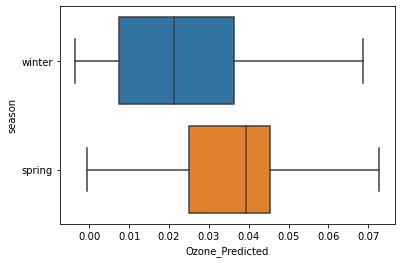

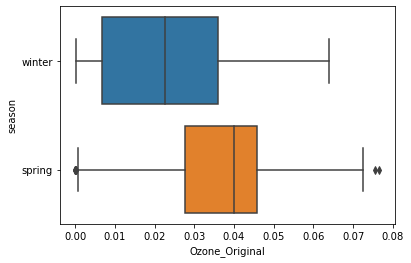

In [121]:
#fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(data=df_qa_results[['Ozone_Predicted','Ozone_Original']],x=df_qa_results.Ozone_Predicted,y=df_qa_results.season)
plt.show()
sns.boxplot(data=df_qa_results[['Ozone_Predicted','Ozone_Original']],x=df_qa_results.Ozone_Original,y=df_qa_results.season)
plt.show()

<AxesSubplot:>

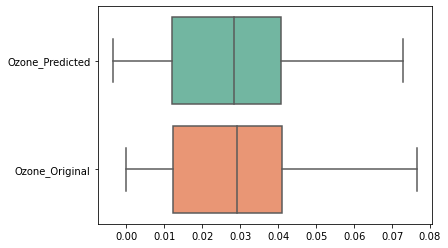

In [122]:
sns.boxplot(data=df_qa_results[['Ozone_Predicted','Ozone_Original']], orient="h", palette="Set2")

In [123]:
df_qa_results.to_csv('QA_Model_Results.csv', index=True)